# NannyML - DataDrift

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nannyml as nml
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from IPython.display import display
from scipy.spatial.transform import Rotation

## Dataset Creation

In [2]:
from menelaus.datasets import make_example_batch_data

In [3]:
df = make_example_batch_data()

In [4]:
df

,year,a,b,c,d,e,f,g,h,i,j,cat,confidence,drift
0,2007,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492,2,0.591243,False
1,2007,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540,2,0.196090,False
2,2007,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082,1,0.504019,False
3,2007,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312,2,0.487307,False
4,2007,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074,1,0.211284,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2021,8434.682418,203.931217,8674.083920,104317.953759,-1.588765,-1.313684,165132.657078,284.979440,7065.994173,83.803525,2,0.641595,True
299996,2021,9701.660570,179.925659,8021.128673,63749.091322,0.412063,0.408188,124630.300901,323.602163,10960.392248,96.796410,1,0.467875,True
299997,2021,6928.908424,210.007943,3312.751778,126116.364855,0.113971,2.432577,107318.127090,214.452933,9491.057615,169.644626,2,0.787726,True
299998,2021,6410.255420,205.092167,6914.861179,158221.742954,0.060710,0.928108,71610.603448,570.911317,8577.498702,61.404365,0,0.689538,True


This function returns a dataframe containing synthetic batch data for use with the repo’s examples. The dataframe’s columns are "year", "a", "b", ... "j", "cat", "confidence", "drift".

- year covers 2007-2021, with 20,000 observations each.

- Features "b", "e", "f" are normally distributed.

- Features "a", "c", "d", "g", "h", "i", "j" have a gamma distribution.

- The "cat" feature contains categorical variables ranging from 1-7, sampled with varying probability.

- "confidence" contains values on [0, 0.6] through 2018, then values on [0.4, 1].

Drift occurs as follows:

- Change the mean of column "b" in 2009. Reverts to original distribution in 2010.

- Change the variance of columns "c" and "d" in 2012 by replacing some samples with the mean. Reverts to original distribution in 2013.

- Increase the correlation of columns "e" and "f" in 2015 (0 correlation to 0.5 correlation).

- Change the mean and variance of column "h" in 2019, and maintain this new distribution going forward. Change the range of the “confidence” column going forward.

- Change the mean and variance of column "j" in 2021.

In [5]:
df = df.iloc[:, :-2]

In [6]:
# add "timestamp" column
df = df.assign(ordered = pd.date_range(start='1/1/2007',end = '12/31/2021', periods = len(df)))

In [7]:
df

,year,a,b,c,d,e,f,g,h,i,j,cat,ordered
0,2007,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492,2,2007-01-01 00:00:00.000000000
1,2007,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540,2,2007-01-01 00:26:17.669258897
2,2007,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082,1,2007-01-01 00:52:35.338517795
3,2007,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312,2,2007-01-01 01:18:53.007776692
4,2007,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074,1,2007-01-01 01:45:10.677035590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2021,8434.682418,203.931217,8674.083920,104317.953759,-1.588765,-1.313684,165132.657078,284.979440,7065.994173,83.803525,2,2021-12-30 22:14:49.322964352
299996,2021,9701.660570,179.925659,8021.128673,63749.091322,0.412063,0.408188,124630.300901,323.602163,10960.392248,96.796410,1,2021-12-30 22:41:06.992223296
299997,2021,6928.908424,210.007943,3312.751778,126116.364855,0.113971,2.432577,107318.127090,214.452933,9491.057615,169.644626,2,2021-12-30 23:07:24.661482176
299998,2021,6410.255420,205.092167,6914.861179,158221.742954,0.060710,0.928108,71610.603448,570.911317,8577.498702,61.404365,0,2021-12-30 23:33:42.330741056


In [8]:
df = df.assign(y_pred_proba = np.random.rand(len(df)))
df = df.assign(y_pred = np.random.randint(3, size=len(df)))
#We are not using them but it is a requirement for NannyML

In [9]:
df

,year,a,b,c,d,e,f,g,h,i,j,cat,ordered,y_pred_proba,y_pred
0,2007,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492,2,2007-01-01 00:00:00.000000000,0.710841,0
1,2007,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540,2,2007-01-01 00:26:17.669258897,0.979875,2
2,2007,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082,1,2007-01-01 00:52:35.338517795,0.036746,1
3,2007,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312,2,2007-01-01 01:18:53.007776692,0.567093,2
4,2007,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074,1,2007-01-01 01:45:10.677035590,0.289595,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2021,8434.682418,203.931217,8674.083920,104317.953759,-1.588765,-1.313684,165132.657078,284.979440,7065.994173,83.803525,2,2021-12-30 22:14:49.322964352,0.908238,0
299996,2021,9701.660570,179.925659,8021.128673,63749.091322,0.412063,0.408188,124630.300901,323.602163,10960.392248,96.796410,1,2021-12-30 22:41:06.992223296,0.959039,2
299997,2021,6928.908424,210.007943,3312.751778,126116.364855,0.113971,2.432577,107318.127090,214.452933,9491.057615,169.644626,2,2021-12-30 23:07:24.661482176,0.745322,0
299998,2021,6410.255420,205.092167,6914.861179,158221.742954,0.060710,0.928108,71610.603448,570.911317,8577.498702,61.404365,0,2021-12-30 23:33:42.330741056,0.457228,2


In [10]:
reference = df[df.year == 2007].iloc[:,1:]
analysis = df[df.year != 2007]

In [11]:
reference

,a,b,c,d,e,f,g,h,i,j,cat,ordered,y_pred_proba,y_pred
0,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492,2,2007-01-01 00:00:00.000000000,0.710841,0
1,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540,2,2007-01-01 00:26:17.669258897,0.979875,2
2,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082,1,2007-01-01 00:52:35.338517795,0.036746,1
3,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312,2,2007-01-01 01:18:53.007776692,0.567093,2
4,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074,1,2007-01-01 01:45:10.677035590,0.289595,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5364.710821,208.382360,9746.552079,101526.208163,-0.698032,-0.881142,70916.529162,14062.450341,10971.969397,917.322988,2,2008-01-01 02:38:16.831656104,0.007196,1
19996,4483.465573,203.131806,6480.968712,139829.904270,0.027155,1.659847,100089.773534,9693.803736,12887.003253,1243.383758,0,2008-01-01 03:04:34.500915000,0.679707,2
19997,5422.838534,201.958562,17409.525027,81433.431760,-2.001971,1.796530,88055.279116,23136.862696,9352.747232,1294.432068,3,2008-01-01 03:30:52.170173900,0.328538,2
19998,13140.759011,192.956187,3374.866352,80084.265655,-1.575061,-0.347297,132191.130413,10319.941080,11238.232369,842.221964,1,2008-01-01 03:57:09.839432796,0.395668,0


In [12]:
column_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g','h','i','j', 'y_pred_proba', 'y_pred']

NannyML monitors ML models in production by doing data drift detection and performance estimation or monitoring. This functionality relies on aggregate metrics evaluated on samples of production data. These samples are called chunks.

In [13]:
calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    treat_as_categorical=['y_pred'],
    timestamp_column_name='ordered',
    continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],
    categorical_methods=['chi2', 'jensen_shannon'],
)

In [14]:
calc.fit(reference)

In [15]:
results = calc.calculate(analysis)

In [16]:
display(results.to_df())

chunk                                    \
              chunk                                     
                key chunk_index start_index end_index   
0          [0:1999]           0           0      1999   
1       [2000:3999]           1        2000      3999   
2       [4000:5999]           2        4000      5999   
3       [6000:7999]           3        6000      7999   
4       [8000:9999]           4        8000      9999   
5     [10000:11999]           5       10000     11999   
6     [12000:13999]           6       12000     13999   
7     [14000:15999]           7       14000     15999   
8     [16000:17999]           8       16000     17999   
9     [18000:19999]           9       18000     19999   
10        [0:27999]           0           0     27999   
11    [28000:55999]           1       28000     55999   
12    [56000:83999]           2       56000     83999   
13   [84000:111999]           3       84000    111999   
14  [112000:139999]           4      112000    139999   
15  [140000:167999]           5      140000    167999   
16  [168000:195999]           6      168000    195999   
17  [196000:223999]           7      196000    223999   
18  [224000:251999]           8      224000    251999   
19  [252000:279999]           9      252000    279999   

                                                                           \
                                                                            
                      start_date                      end_date     period   
0  2007-01-01 00:00:00.000000000 2007-02-06 12:02:40.848536161  reference   
1  2007-02-06 12:28:58.517795059 2007-03-15 00:31:39.366331221  reference   
2  2007-03-15 00:57:57.035590118 2007-04-20 13:00:37.884126280  reference   
3  2007-04-20 13:26:55.553385178 2007-05-27 01:29:36.401921338  reference   
4  2007-05-27 01:55:54.071180236 2007-07-02 13:58:34.919716398  reference   
5  2007-07-02 14:24:52.588975296 2007-08-08 02:27:33.437511456  reference   
6  2007-08-08 02:53:51.106770356 2007-09-13 14:56:31.955306516  reference   
7  2007-09-13 15:22:49.624565412 2007-10-20 03:25:30.473101576  reference   
8  2007-10-20 03:51:48.142360472 2007-11-25 15:54:28.990896636  reference   
9  2007-11-25 16:20:46.660155532 2008-01-01 04:23:27.508691692  reference   
10 2008-01-01 04:49:45.177950592 2009-05-26 11:09:06.757822528   analysis   
11 2009-05-26 11:35:24.427081424 2010-10-19 17:54:46.006953344   analysis   
12 2010-10-19 18:21:03.676212240 2012-03-14 00:40:25.256084160   analysis   
13 2012-03-14 01:06:42.925343072 2013-08-07 07:26:04.505215008   analysis   
14 2013-08-07 07:52:22.174473888 2014-12-31 14:11:43.754345824   analysis   
15 2014-12-31 14:38:01.423604736 2016-05-25 20:57:23.003476672   analysis   
16 2016-05-25 21:23:40.672735552 2017-10-19 03:43:02.252607488   analysis   
17 2017-10-19 04:09:19.921866368 2019-03-14 10:28:41.501738304   analysis   
18 2019-03-14 10:54:59.170997184 2020-08-06 17:14:20.750869120   analysis   
19 2020-08-06 17:40:38.420128064 2021-12-31 00:00:00.000000000   analysis   

                    a                                  ...    y_pred_proba  \
   kolmogorov_smirnov                                  ...  jensen_shannon   
                value upper_threshold lower_threshold  ... lower_threshold   
0            0.026650        0.032572            None  ...            None   
1            0.015150        0.032572            None  ...            None   
2            0.023050        0.032572            None  ...            None   
3            0.007900        0.032572            None  ...            None   
4            0.016700        0.032572            None  ...            None   
5            0.019950        0.032572            None  ...            None   
6            0.011650        0.032572            None  ...            None   
7            0.018600        0.032572            None  ...            None   
8            0.014750        0.032572            None  ...            No

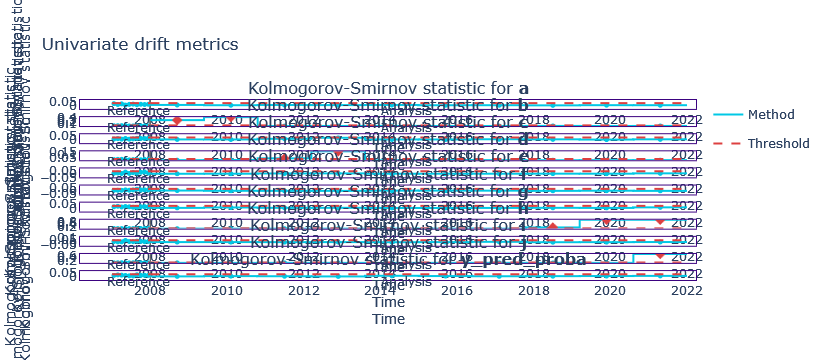

In [18]:
figure = results.filter(column_names=results.continuous_column_names, methods=['kolmogorov_smirnov']).plot(kind='drift')
figure.show()

### Results

- Drift in 'b' is detected in 2009 and 2010 (as it reverts to normal)
- Drift in 'd' is detected in 2012 and 2013 (as it reverts to normal)
- Drift in 'h' is detected in 2019, 2020 and 2021
- Drift in 'j' is detected in 2021
- Extra annotations: 'c'-s JS-Distance is really close to the threshold in 2013, where it is supposed to detect a drift